In [1]:
import torch
import tqdm
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from flexicubes import FlexiCubes
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import plotly.io as pio
pio.renderers.default = 'iframe'

iterations = 201
batch = 8
learning_rate = 0.01
voxel_grid_res = 25
device = 'cpu'
sdf_regularizer = 0.2

In [2]:
alfa = 1

def MyAnd(x,y):
    return (1/(1+alfa))*(x+y-(x*x+y*y-2*alfa*x*y)**0.5)
def MyOr(x,y):
    return (1/(1+alfa))*(x+y+(x*x+y*y-2*alfa*x*y)**0.5)

def f1(x, y, z):
    return 0.25 - x**2 - y**2 - z**2
def f2(x, y, z):
    return 2-(x-1)**2-(y-1)**2 - (z-1)**2     

def f(x, y, z):
    v1=f1(x,y,z)
    v2=f2(x,y,z)
    return MyAnd(v1,-v2)

def res(xyz):
    x, y, z = grid_verts.split(1, dim=1)
    return f(x, y, z)

In [3]:
def render_mesh(verts, faces):
    fig = go.Figure(data=[go.Mesh3d(
        x=verts[:, 0],
        y=verts[:, 1],
        z=verts[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        opacity=0.5,
        colorscale="Jet",
    )])
    fig.show()

def render_static(verts, faces):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    mesh = Poly3DCollection(verts[faces])
    mesh.set_edgecolor('k')
    ax.add_collection3d(mesh)
    plt.tight_layout()
    plt.show()

def render(mesh):
    (verts, faces) = mesh
    verts = verts.cpu().detach().numpy()
    faces = faces.cpu().detach().numpy()
    render_static(verts, faces)
    # render_mesh(verts, faces)

In [4]:
fc = FlexiCubes(device)
x_nx3, cube_fx8 = fc.construct_voxel_grid(voxel_grid_res)

In [5]:
sdf = torch.rand_like(x_nx3[:, 0]) - 0.1
sdf = torch.nn.Parameter(sdf.clone().detach(), requires_grad=True)

In [6]:
weight = torch.zeros((cube_fx8.shape[0], 21), dtype=torch.float, device=device)
weight = torch.nn.Parameter(weight.clone().detach(), requires_grad=True)

In [7]:
all_edges = cube_fx8[:, fc.cube_edges].reshape(-1, 2)
grid_edges = torch.unique(all_edges, dim=0)

In [8]:
deform = torch.nn.Parameter(torch.zeros_like(x_nx3), requires_grad=True)
grid_verts = x_nx3 + (2-1e-8) / (voxel_grid_res * 2) * torch.tanh(deform)

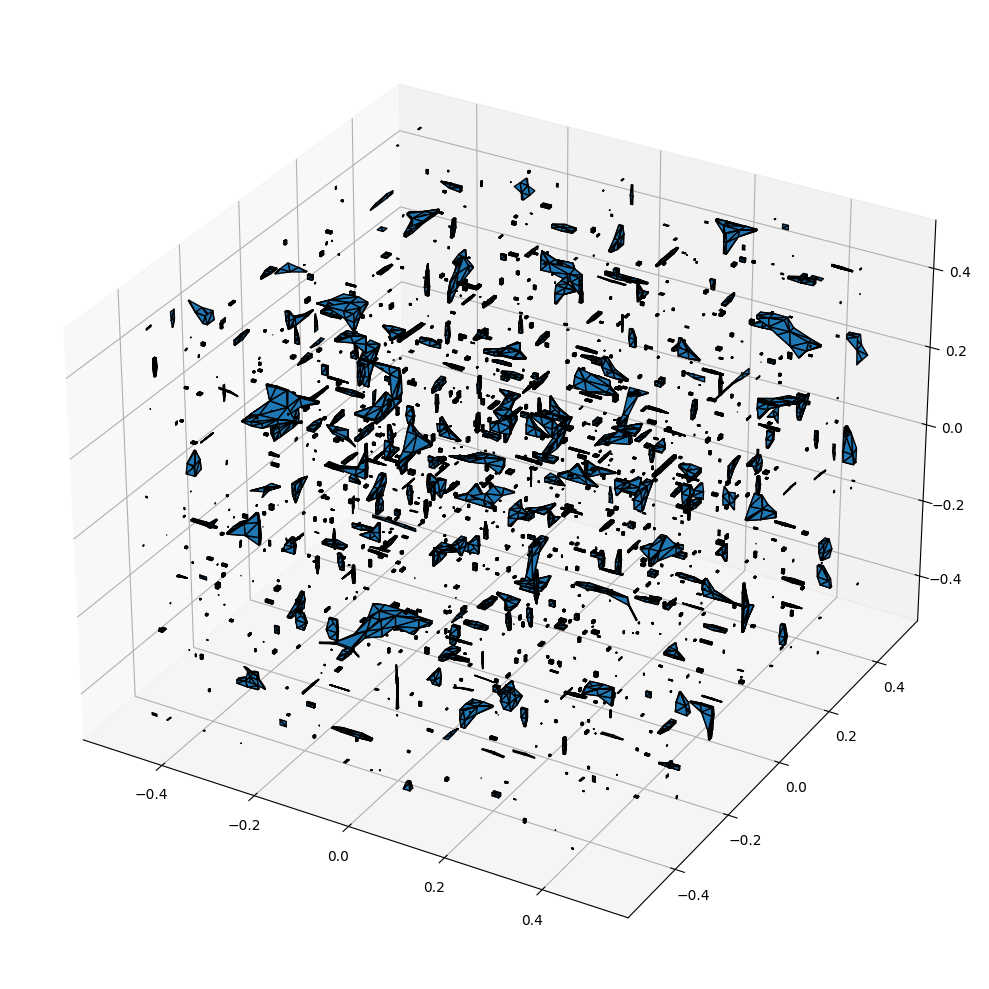

In [9]:
vertices, faces, L_dev = fc(
    grid_verts,
    sdf,
    cube_fx8,
    voxel_grid_res,
    beta_fx12=weight[:,:12],
    alpha_fx8=weight[:,12:20],
    gamma_f=weight[:,20],
    training=False)
init_mesh = (vertices, faces)
render(init_mesh)

In [10]:
def lr_schedule(iteration):
    return max(0.0, 10 ** (-(iteration) * 0.0002))
optimizer = torch.optim.Adam([sdf, weight, deform], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lr_schedule
)

In [11]:
def sdf_diff(sdf, verts):
    target = res(verts).reshape(-1)
    diff = ((target.nan_to_num(0.1)-sdf.nan_to_num(0.1))**2).mean()
    diff = ((target-sdf)**2).mean()
    return diff

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:26<00:00,  7.64it/s]


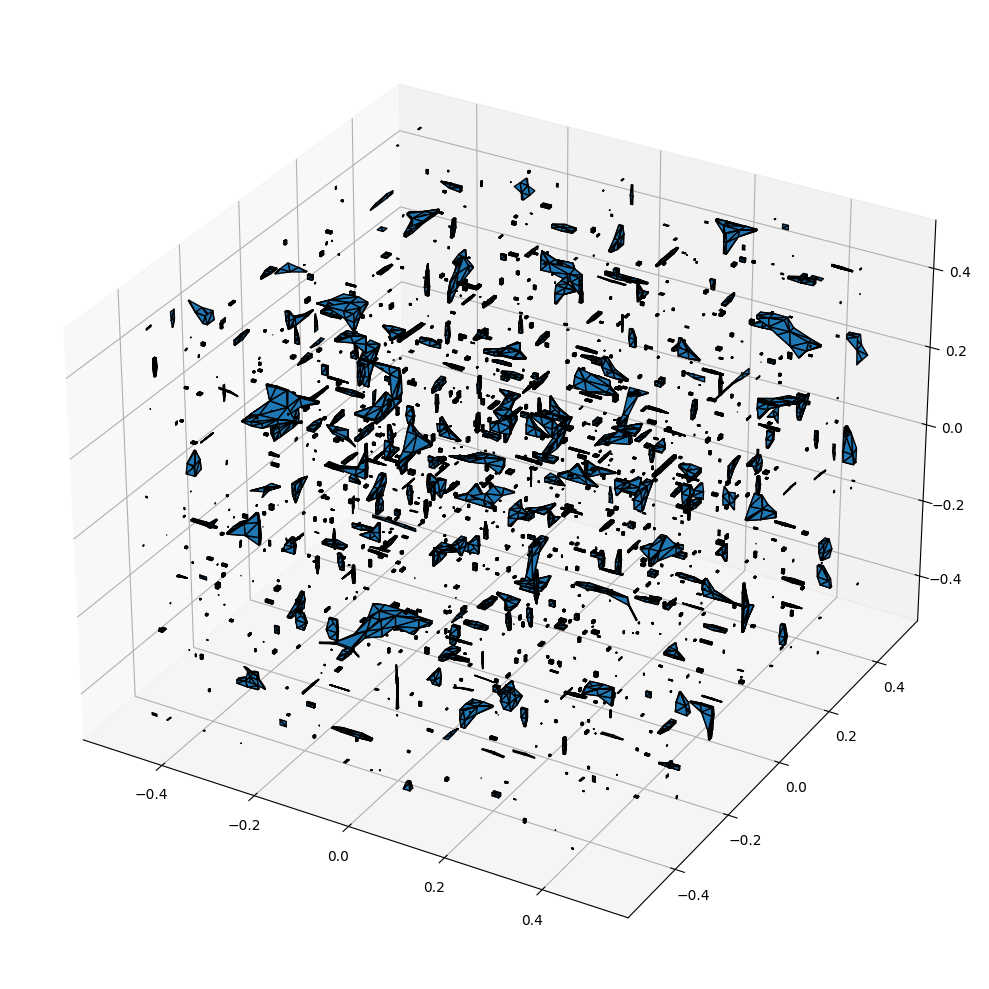

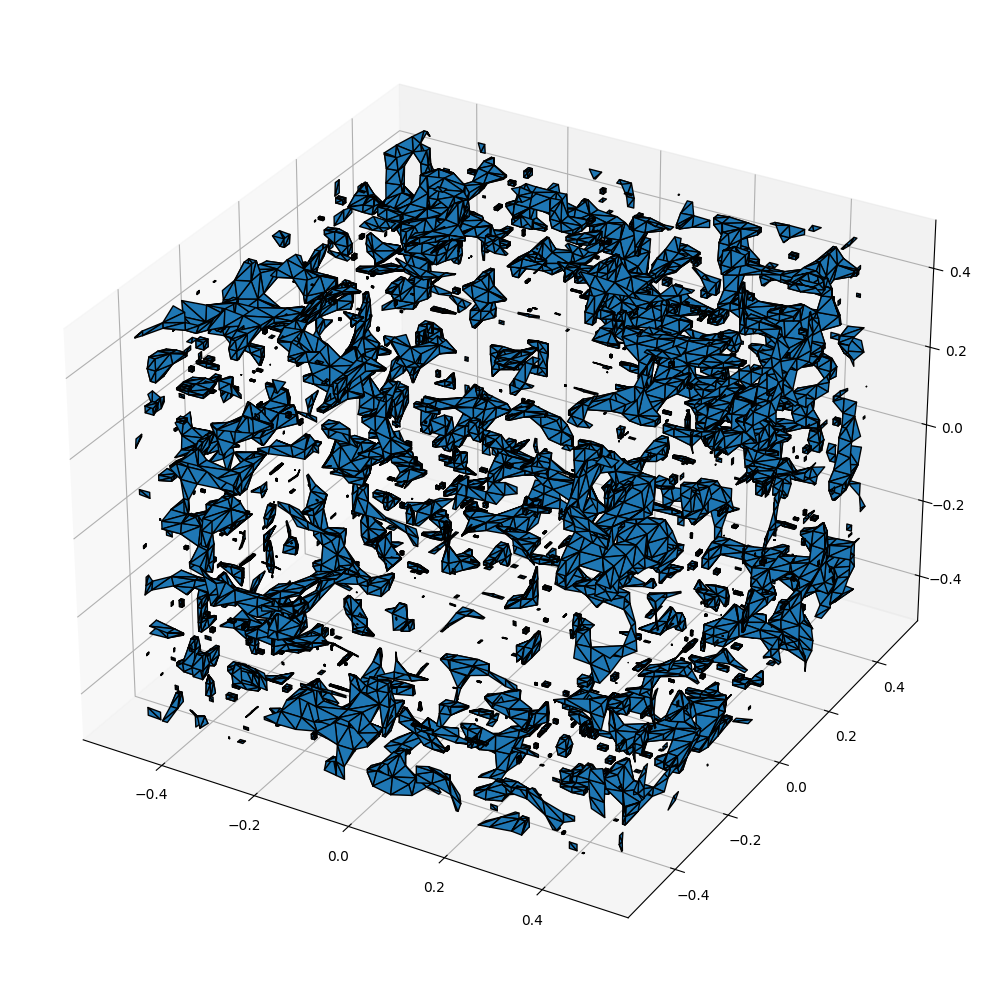

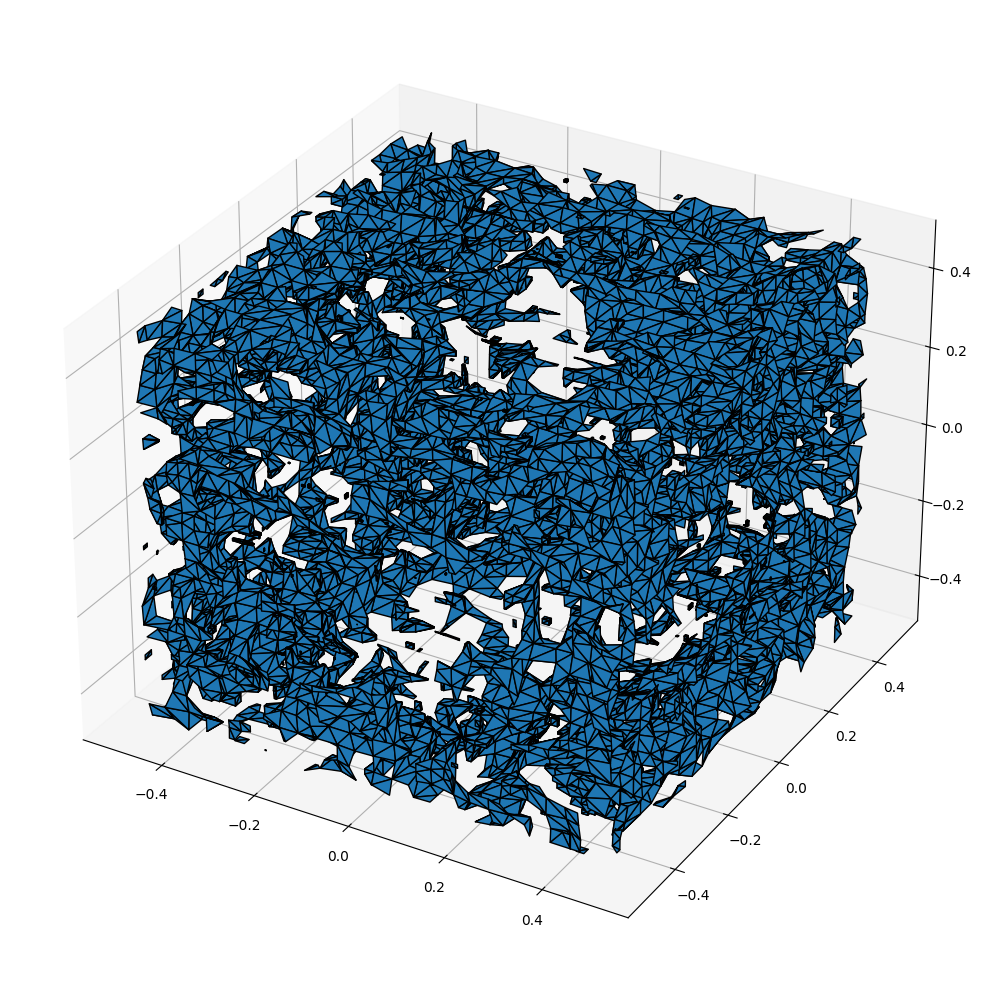

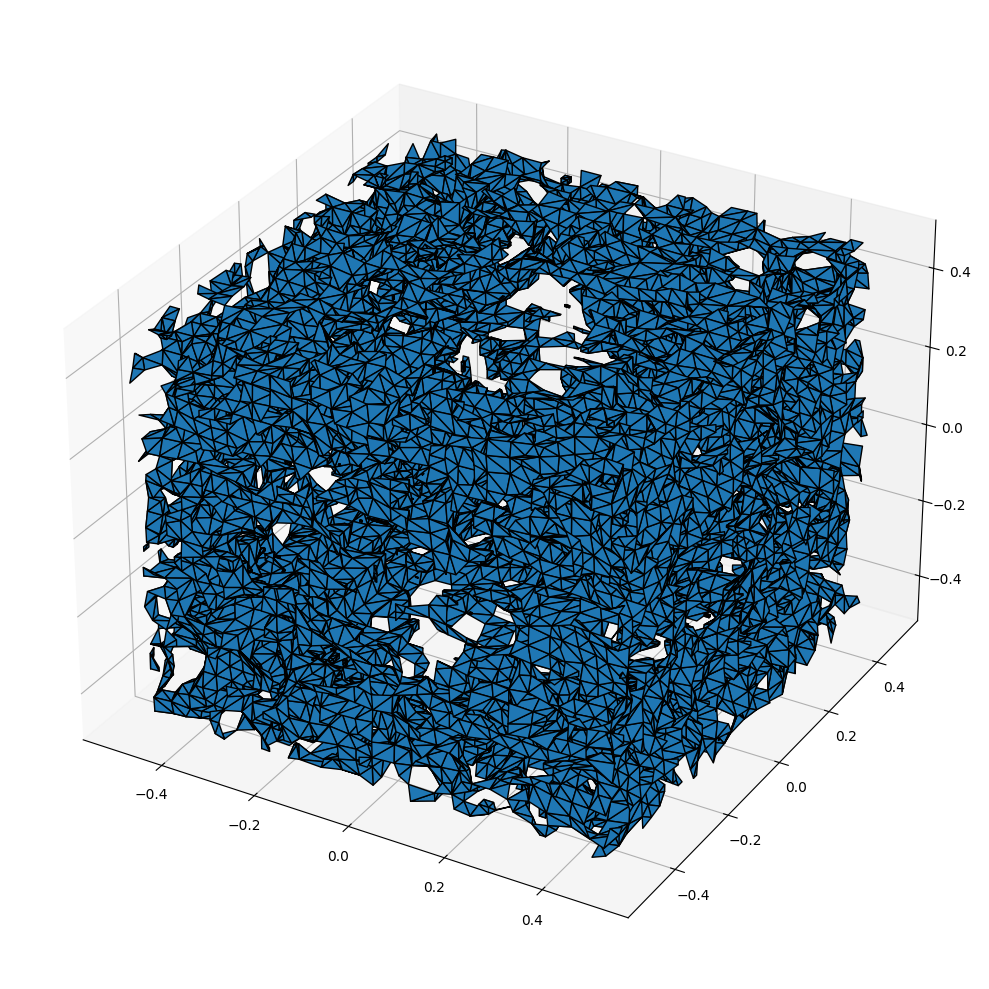

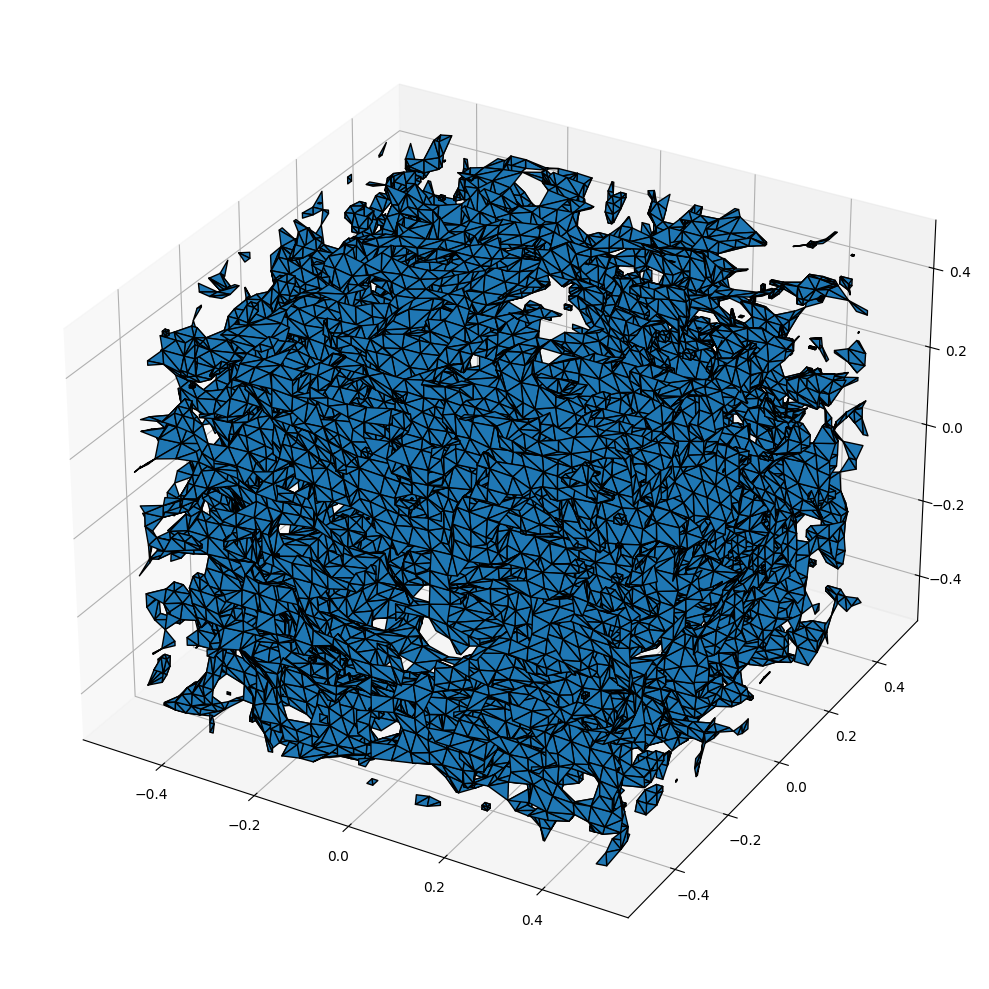

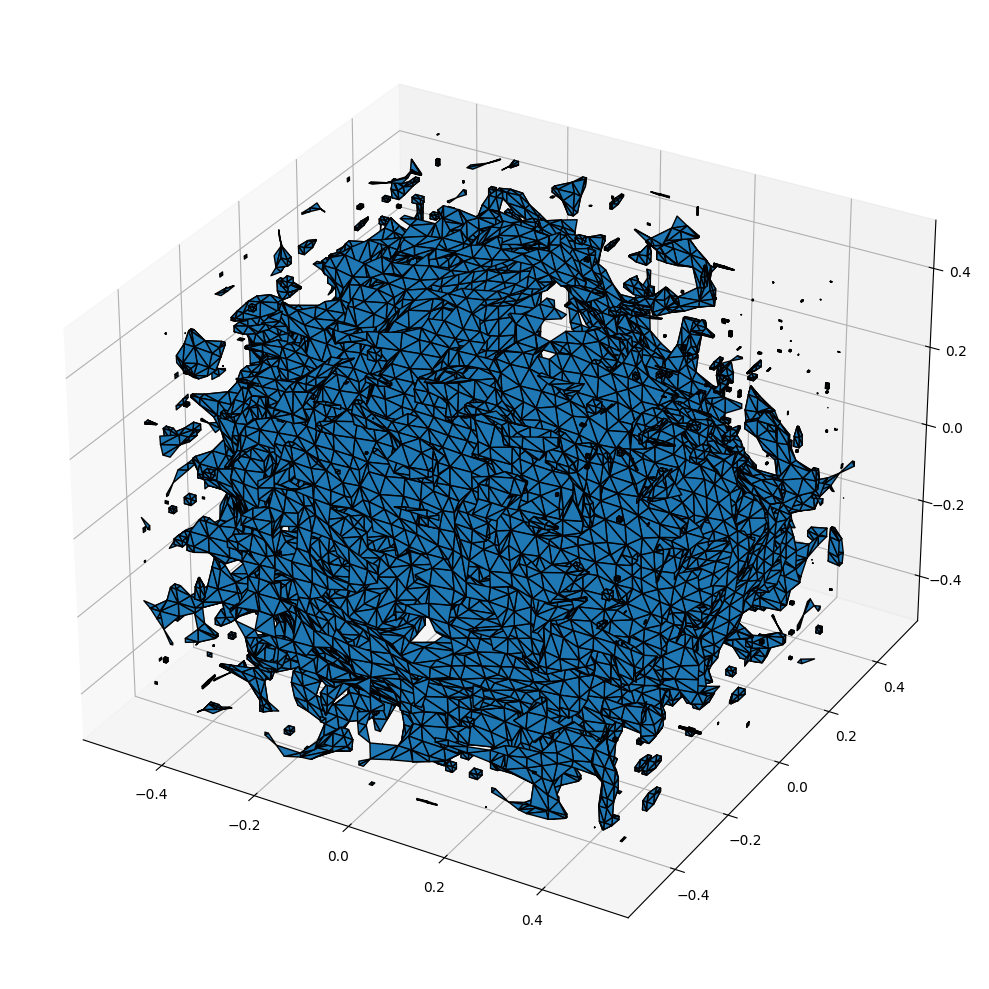

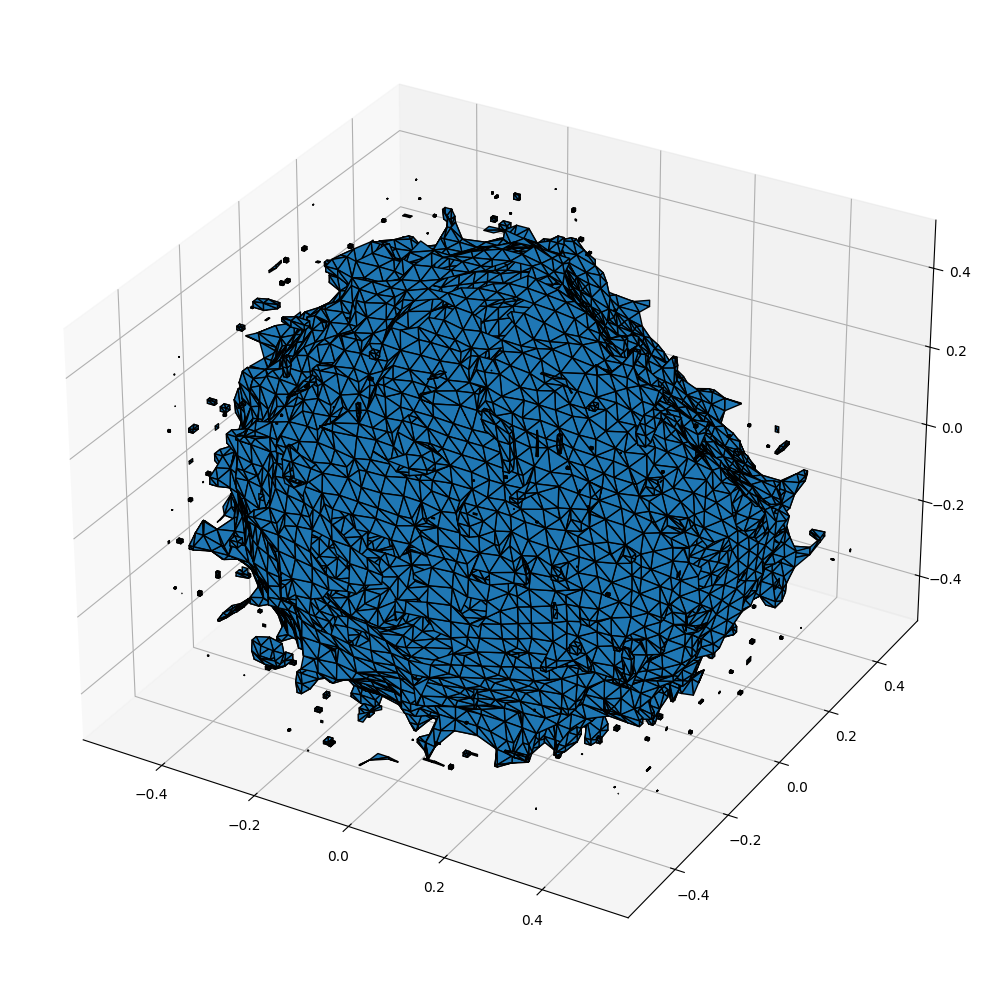

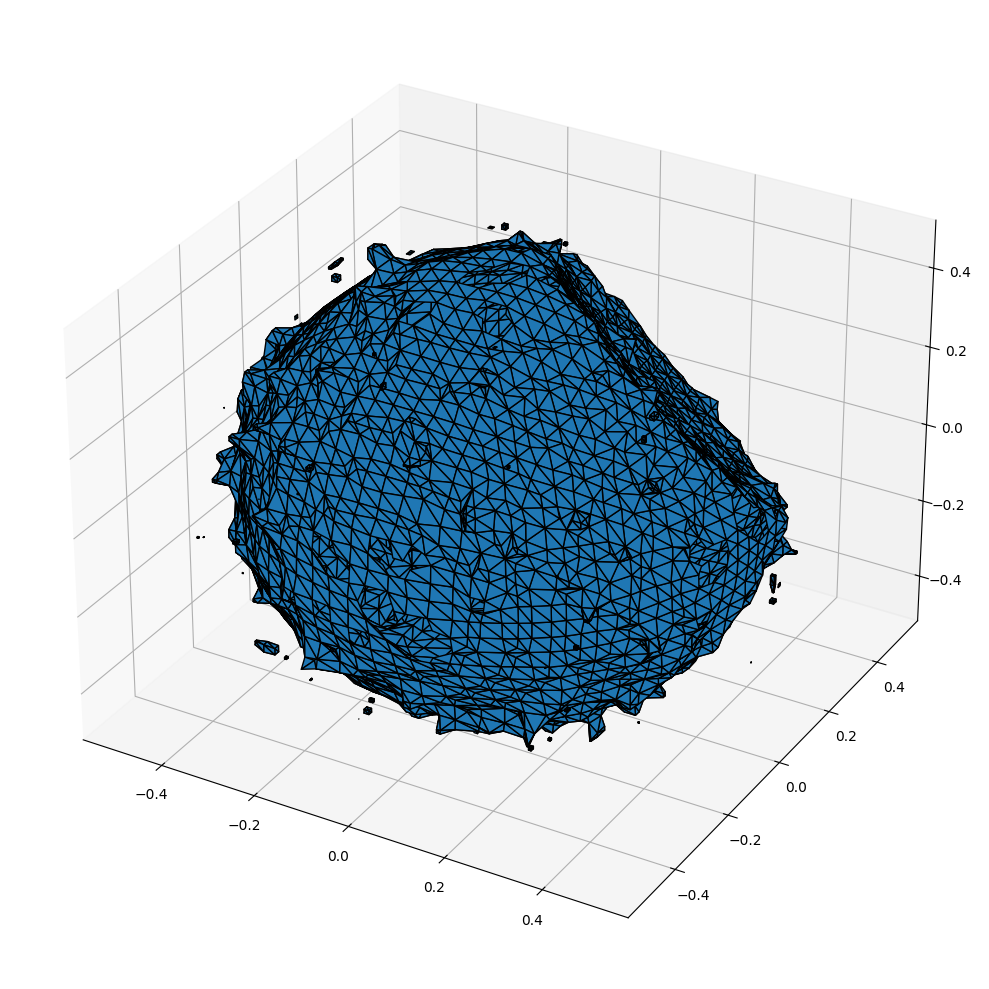

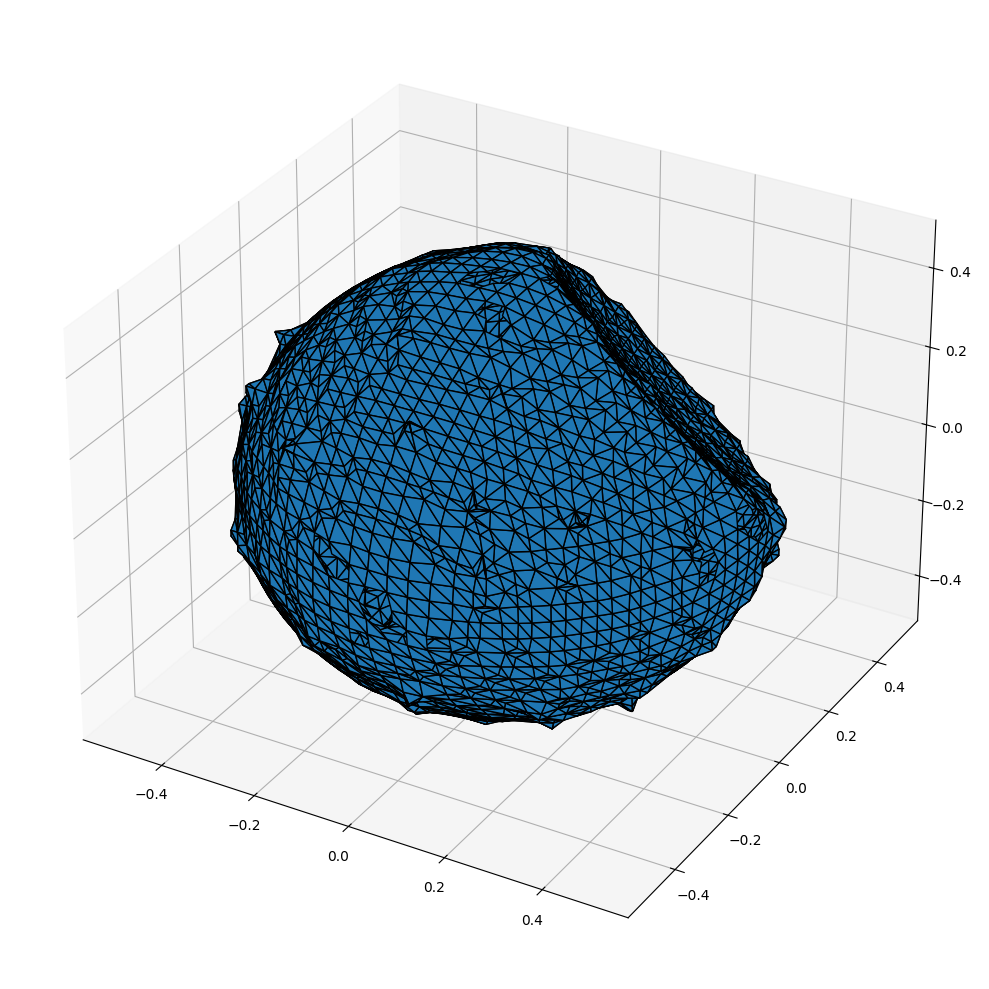

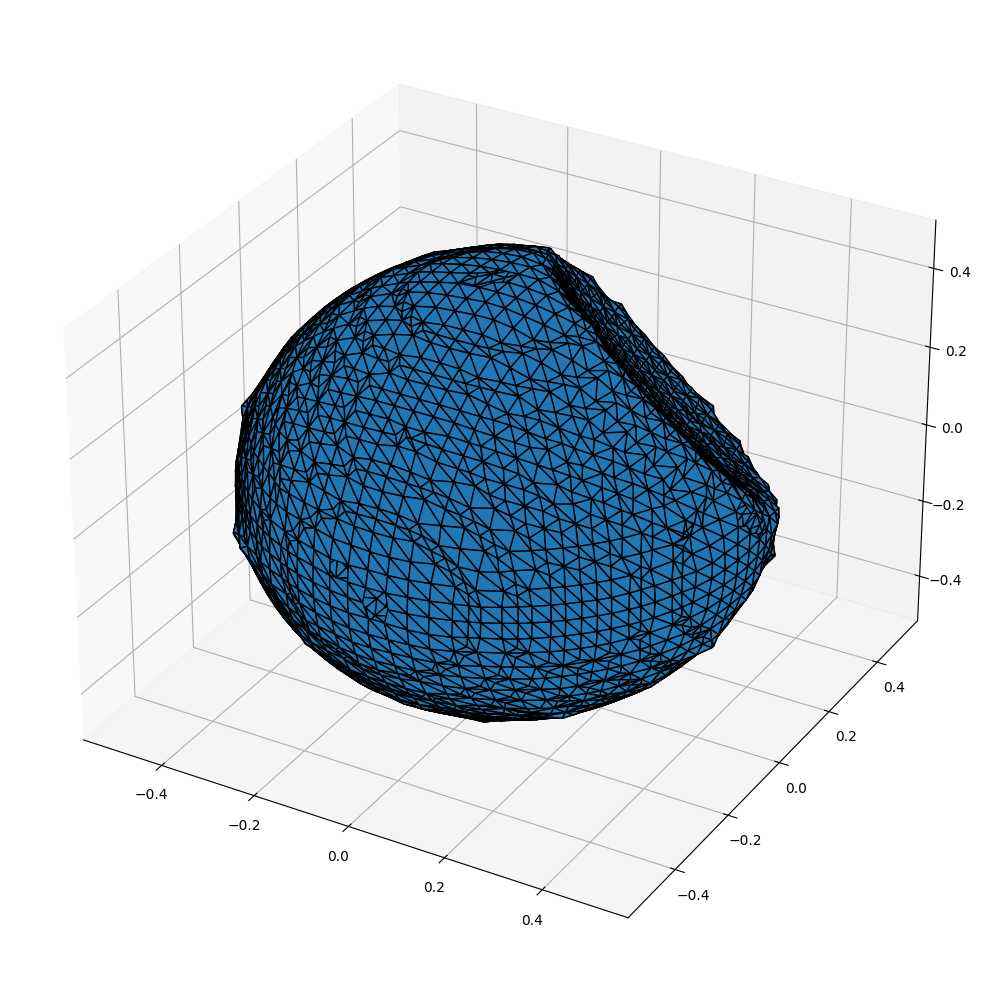

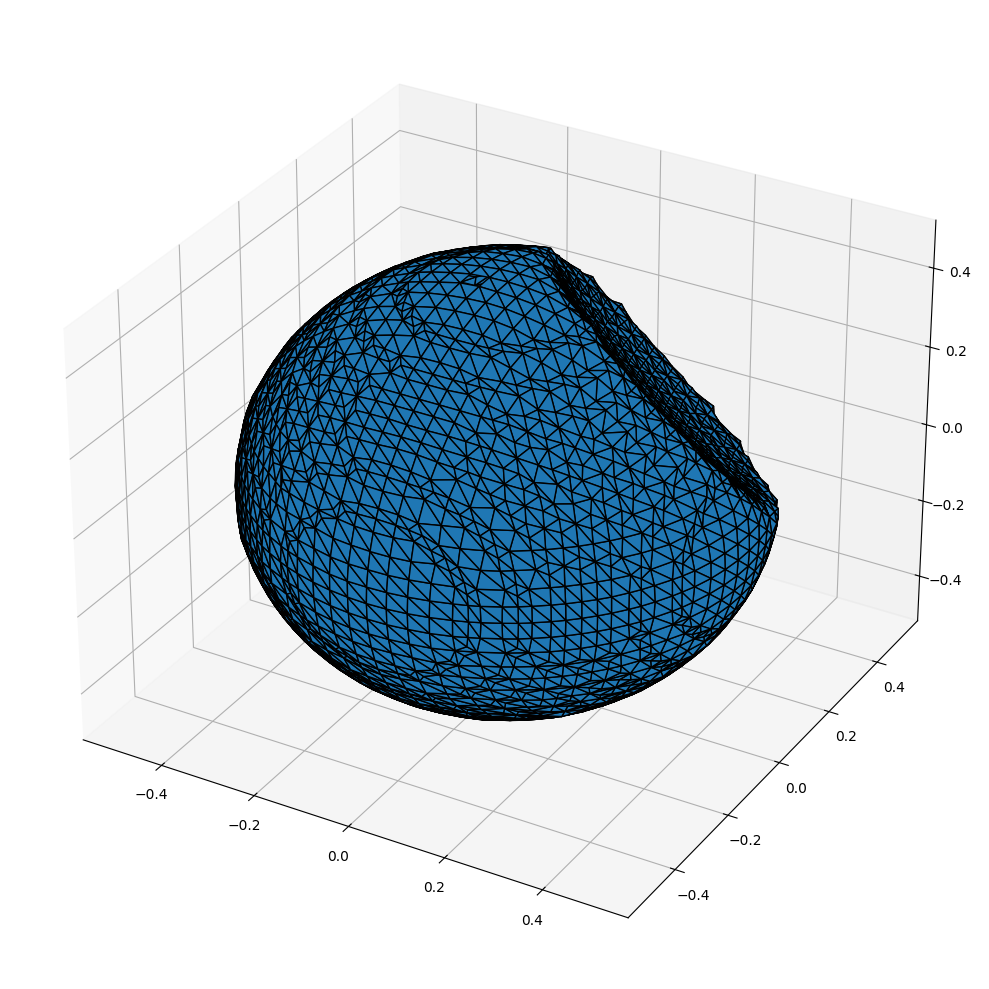

In [12]:
intermediate_results = [init_mesh]
for it in tqdm.tqdm(range(iterations)):
    optimizer.zero_grad()
    grid_verts = x_nx3
    vertices, faces, L_dev = fc(
        grid_verts,
        sdf,
        cube_fx8,
        voxel_grid_res,
        beta_fx12=weight[:,:12],
        alpha_fx8=weight[:,12:20],
        gamma_f=weight[:,20],
        training=True
    )
    sdf_loss = sdf_diff(sdf, grid_verts)
    total_loss = sdf_loss
    total_loss.backward()
    optimizer.step()
    scheduler.step()
    if (it + 1) % 20 == 0:
        with torch.no_grad():
            vertices, faces, L_dev = fc(
                grid_verts,
                sdf,
                cube_fx8,
                voxel_grid_res,
                beta_fx12=weight[:,:12],
                alpha_fx8=weight[:,12:20],
                gamma_f=weight[:,20],
                training=False)
            intermediate_results.append((vertices, faces))

for m in intermediate_results:
    render(m)

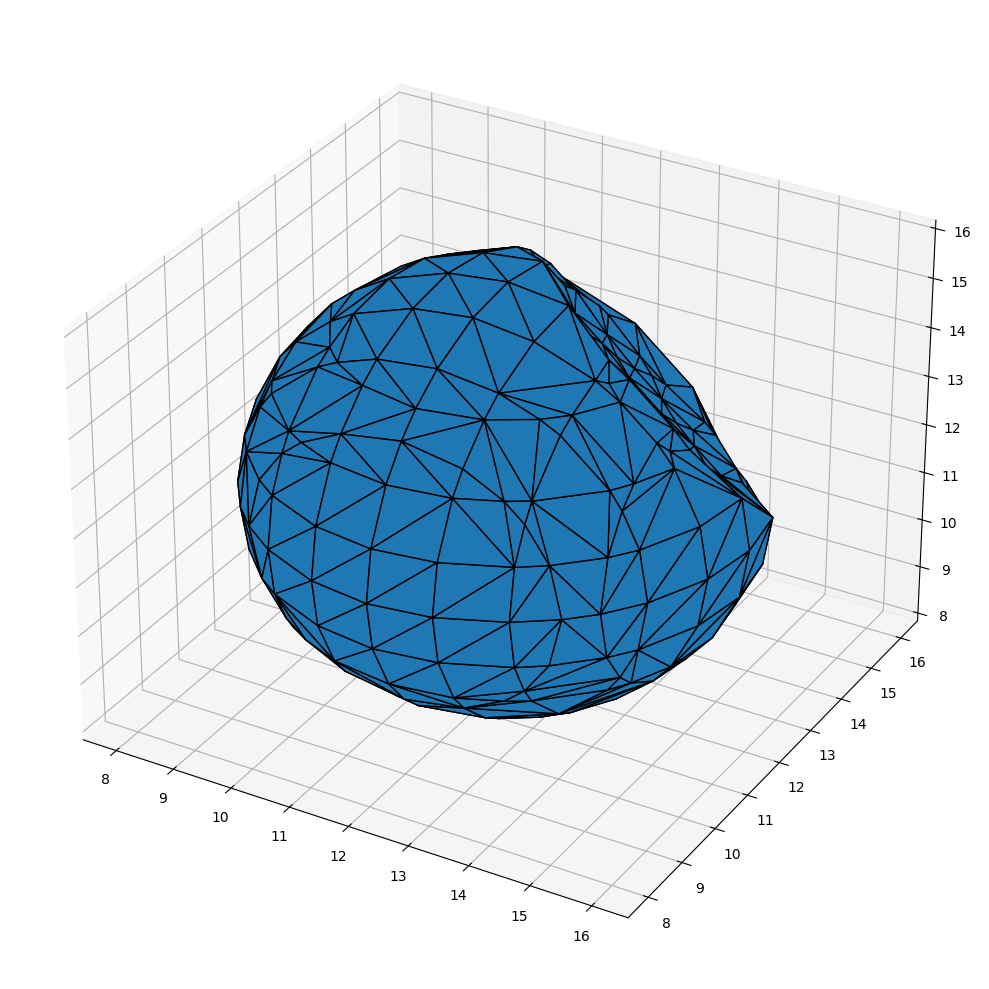

In [13]:
from skimage.measure import marching_cubes
xmin, xmax = -1.5, 1.5
ymin, ymax = -1.5, 1.5
zmin, zmax = -1.5, 1.5

x = np.linspace(xmin, xmax, voxel_grid_res)
y = np.linspace(ymin, ymax, voxel_grid_res)
z = np.linspace(zmin, zmax, voxel_grid_res)
X, Y, Z = np.meshgrid(x, y, z, indexing="ij")

volume = f(X, Y, Z)

verts, faces, normals, values = marching_cubes(volume, level=0.0)

mc_mesh = (torch.from_numpy(verts.copy()), torch.from_numpy(faces.copy()))
render(mc_mesh)